In [2]:
# Standard library imports
import json
import sys
from collections import Counter
from functools import reduce
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import xycmap

# Local application imports
sys.path.append(str(Path.cwd().parent))
from src.utils import filter_by_hour

/tmp/ipykernel_2008881/2380577162.py:14: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/opt/conda/envs/fpe-model.dev-amrita/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DATA_DIR = '../../../data/Streamflow/fpe_stations'
SAVE_DIR = '../data/processed/'

In [4]:
# List fpe sites
sites = sorted([
    f.stem
    for f in Path(DATA_DIR).iterdir()
    if f.is_dir() and not f.stem.startswith('.') and not f.stem in ['FOXRC', 'GREENR', 'LANESV', 'WESTKILL', 'VLYB', 'AVERYBB']
])
display(sites)

['Avery Brook_Bridge_01171000',
 'Avery Brook_River Left_01171000',
 'Avery Brook_River Right_01171000',
 'Avery Brook_Side_01171000',
 'Sanderson Brook_01171010',
 'West Branch Swift River_01174565',
 'West Brook 0_01171100',
 'West Brook Lower_01171090',
 'West Brook Reservoir_01171020',
 'West Brook Upper_01171030',
 'West Whately_01171005']

In [5]:
def load_site_data(site, data_dir=DATA_DIR):
    # read timezone from stations.json file
    site_json = json.load(open(Path(data_dir, site, 'FLOW_CFS', 'station.json'), 'r'))
    site_timezone = site_json['timezone']
    
    # read data, convert UTC to site timezone
    data = pd.read_csv(Path(data_dir, site, 'FLOW_CFS', 'images.csv'))
    data['timestamp'] = pd.to_datetime(data['timestamp']).dt.tz_convert(site_timezone)
    
    return data

def load_site_annotations(site, data_dir=DATA_DIR):
    # read timezone from stations.json file
    site_json = json.load(open(Path(data_dir, site, 'FLOW_CFS', 'station.json'), 'r'))
    site_timezone = site_json['timezone']

    annotations = pd.read_csv(Path(data_dir, site, 'FLOW_CFS', 'annotations.csv'))
    annotations['left.timestamp'] = pd.to_datetime(annotations['left.timestamp']).dt.tz_convert(site_timezone)
    annotations['right.timestamp'] = pd.to_datetime(annotations['right.timestamp']).dt.tz_convert(site_timezone)
    return annotations


In [24]:
def split_annotations(annotations, train_size=0.9, test_size=0.1, seed=42, 
                      method='kernighan-lin', verbose=False):
    # Ensure train_size + test_size is close to 1
    assert np.isclose(train_size + test_size, 1), \
        'train_size + test_size must be close to 1'
    
    if method == 'kernighan-lin':
        # Create a graph from annotations
        G = create_graph_from_annotations(annotations)
        
        # Initialize two partitions with the correct size
        nodes = list(G.nodes)
        rng = np.random.default_rng(seed)
        rng.shuffle(nodes)
        n1 = int(len(nodes) * train_size)
        partition = (set(nodes[:n1]), set(nodes[n1:]))
        
        # Split the graph into two partitions using the Kernighan-Lin algorithm
        partition = nx.algorithms.community.kernighan_lin_bisection(
            G, weight="weight", partition=partition, seed=seed)
        if verbose:
            print(f'Partition sizes (nodes): {len(partition[0])}, {len(partition[1])}')
            # Weight of edges within each partition
            within_partition_weight = [
                sum(G[u][v]['weight'] for u, v in nx.edges(G, partition[i]))
                for i in range(2)
            ]
            print(f'Partition sizes (edge weights): {within_partition_weight}')
            # Cut size is the total weight of edges between the two partitions
            cut_size = nx.algorithms.cuts.cut_size(G, partition[0], partition[1], weight='weight')
            print(f'Cut size: {cut_size}')

        # Split annotations into two dataframes based on the partition
        p1 = annotations[annotations['left.timestamp'].dt.date.isin(partition[0]) & 
                     annotations['right.timestamp'].dt.date.isin(partition[0])].copy()
        p2 = annotations[annotations['left.timestamp'].dt.date.isin(partition[1]) & 
                        annotations['right.timestamp'].dt.date.isin(partition[1])].copy()
        if len(partition[0]) == n1:
            return p1, p2
        else:
            return p2, p1
    else:
        raise NotImplementedError(f'Method {method} not implemented')


def create_graph_from_annotations(annotations):
    G = nx.Graph()
    for _, row in annotations.iterrows():
        left = row['left.timestamp'].date()
        right = row['right.timestamp'].date()
        if not G.has_node(left):
            G.add_node(left)
        if not G.has_node(right):
            G.add_node(right)
        if G.has_edge(left, right):
            G[left][right]['weight'] += 1
        else:
            G.add_edge(left, right, weight=1)
    return G



In [46]:
annotations.columns

Index(['annotation_id', 'user_id', 'station_id', 'station_name',
       'duration_sec', 'n', 'url', 'rank', 'comment', 'left.imageId',
       'left.attributes', 'right.imageId', 'right.attributes', 'pair_id',
       'left.timestamp', 'left.value', 'left.url', 'left.filename',
       'right.timestamp', 'right.value', 'right.url', 'right.filename',
       'delta_value', 'avg_value', 'rel_delta_value', 'true_rank'],
      dtype='object')

In [59]:
exp_name = 'kernighan-lin_test.vary_n_train_annot'
for site in sites:
    print(site)
    # Create directory to save data
    Path(SAVE_DIR, site, 'FLOW_CFS', exp_name).mkdir(parents=True, exist_ok=True)
    # Load data and annotations
    data = load_site_data(site)
    annotations = load_site_annotations(site)
    tot_annotations = len(annotations)
    unknown_annotations = len(annotations[annotations['rank'] == 'UNKNOWN'])
    user9bc0_annotations = len(annotations[annotations['user_id'] == '9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17'])
    before_7am_annotations = len(annotations[(annotations['left.timestamp'].dt.hour < 7) | (annotations['right.timestamp'].dt.hour < 7)])
    after_7pm_annotations = len(annotations[(annotations['left.timestamp'].dt.hour > 18 )| (annotations['right.timestamp'].dt.hour > 18)])
    print(f'\tTotal annotations: {tot_annotations}')
    print(f'\tUNKNOWN annotations: {unknown_annotations}')
    print(f'\tUser 9bc0... annotations: {user9bc0_annotations}')
    print(f'\tBefore 7am annotations: {before_7am_annotations}')
    print(f'\tAfter 7pm annotations: {after_7pm_annotations}')
    # Filter out annotations with rank UNKNOWN
    annotations = annotations[annotations['rank'] != 'UNKNOWN']
    # Filter out annotations from annotator 9bc0...
    annotations = annotations[annotations['user_id'] != '9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17']
    # Filter out annotations whose left timestamp or right timestamp is before 7am or after 7pm
    annotations = filter_by_hour(annotations, 7, 18, datetime_col='left.timestamp')
    annotations = filter_by_hour(annotations, 7, 18, datetime_col='right.timestamp')
    print(f'\tFiltered annotations: {len(annotations)}')
    
    n_tot_annot = len(annotations)
    # Split annotations into training-val and test sets
    train_annotations, test_annotations = split_annotations(annotations, method='kernighan-lin')
    n_discarded_annot = n_tot_annot - len(train_annotations) - len(test_annotations)
    # Randomly sample 10% of the training annotations for validation
    valid_annotations = train_annotations.sample(frac=0.1, random_state=42)
    train_annotations = train_annotations.drop(valid_annotations.index)
    # SAVE TRAIN, VALID, TEST
    train_annotations.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-train.csv'))
    valid_annotations.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-val.csv'))
    test_annotations.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-test.csv'))

    # Generate nested subsets of the training data in increments of 500 samples
    subset_sizes = [500 * i for i in range(1, len(train_annotations) // 500 + 1)]
    # create random permutation of indices
    subset_indices = np.random.permutation(len(train_annotations))
    # create subsets
    for subset_size in subset_sizes:
        subset = train_annotations.iloc[subset_indices[:subset_size]]
        subset.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, f'pairs-train-{subset_size}.csv'))
        print(f'saved subset of size {subset_size}')
    # break

    

Avery Brook_Bridge_01171000
	Total annotations: 5148
	UNKNOWN annotations: 747
	User 9bc0... annotations: 0
	Before 7am annotations: 1210
	After 7pm annotations: 966
	Filtered annotations: 3148
saved subset of size 500
saved subset of size 1000
saved subset of size 1500
saved subset of size 2000
saved subset of size 2500
Avery Brook_River Left_01171000
	Total annotations: 2516
	UNKNOWN annotations: 109
	User 9bc0... annotations: 0
	Before 7am annotations: 4
	After 7pm annotations: 4
	Filtered annotations: 2406
saved subset of size 500
saved subset of size 1000
saved subset of size 1500
Avery Brook_River Right_01171000
	Total annotations: 2500
	UNKNOWN annotations: 105
	User 9bc0... annotations: 0
	Before 7am annotations: 0
	After 7pm annotations: 0
	Filtered annotations: 2395
saved subset of size 500
saved subset of size 1000
saved subset of size 1500
Avery Brook_Side_01171000
	Total annotations: 2500
	UNKNOWN annotations: 59
	User 9bc0... annotations: 0
	Before 7am annotations: 0
	Aft

West Branch Swift River_01174565
Number of annotations: 5084
Number of annotations (after filtering out UNKNOWN): 4053
Number of unique dates in annotations: 976
>>> Creating graph
Number of nodes (dates): 976
Number of edges: 3996
Total edge weight (num annotations): 4053
Number of connected components: 2
--------------------------------------------------------------------------------
>>> Initializing graph partition
Target number of training days: 878
Target number of test days: 98
Number of nodes in initial training set: 878
Number of nodes in initial test set: 98
Initial cut size: 734
>>> Partitioning graph using Kernighan-Lin algorithm
Number of nodes in partition 1: 98
Number of nodes in partition 2: 878
Cut size (manual): 86
Cut size (nx): 86
Total weight of edges in partition 1: 17
Total weight of edges in partition 2: 3950


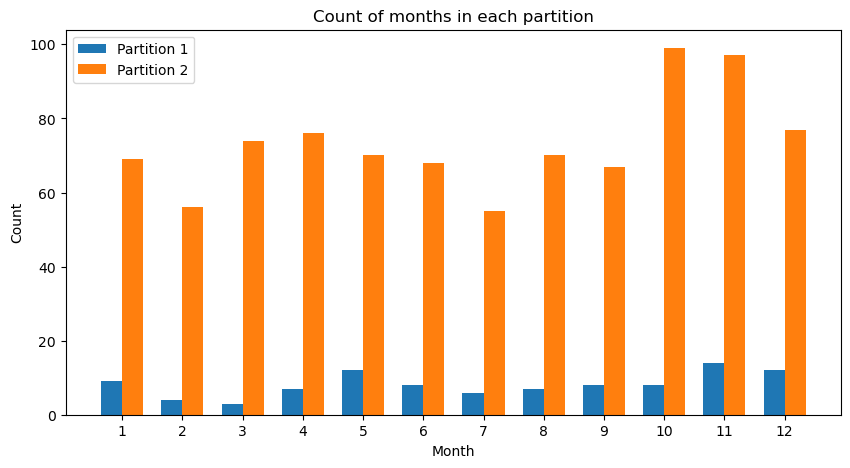

In [7]:
site = sites[5]
print(site)
print('='*80)
data = load_site_data(site)
annotations = load_site_annotations(site)
print(f'Number of annotations: {len(annotations)}')
annotations = annotations[annotations['rank'] != 'UNKNOWN'] # drop UNKNOWN
print(f'Number of annotations (after filtering out UNKNOWN): {len(annotations)}')

# get number of dates in annotations under left.timestamp and right.timestamp
left_dates = annotations['left.timestamp'].dt.date
right_dates = annotations['right.timestamp'].dt.date
unique_dates = set(left_dates).union(set(right_dates))
print(f'Number of unique dates in annotations: {len(unique_dates)}')

# create an empty undirected graph
print('>>> Creating graph')
G = nx.Graph()
# iterate through rows of annotations and for each row, add an edge between the left and right timestamps
# creating nodes if they don't exist; and increasing the weight of the edge if it does exist
for _, row in annotations.iterrows():
    left = row['left.timestamp'].date()
    right = row['right.timestamp'].date()
    if not G.has_node(left):
        G.add_node(left)
    if not G.has_node(right):
        G.add_node(right)
    if G.has_edge(left, right):
        G[left][right]['weight'] += 1
    else:
        G.add_edge(left, right, weight=1)
# print the number of nodes (dates)
print(f'Number of nodes (dates): {G.number_of_nodes()}')
# print the number of edges (connections between dates)
print(f'Number of edges: {G.number_of_edges()}')
# print total edge weight
total_edge_weight = sum([G[u][v]['weight'] for u, v in G.edges()])
print(f'Total edge weight (num annotations): {total_edge_weight}')

# # add nodes for dates in the data if they don't exist if they are within 3 days of an existing node
# for timestamp in data['timestamp']:
#     date = timestamp.date()
#     if not G.has_node(date):
#         for node in G.nodes():
#             if abs((date - node).days) <= 1:
#                 G.add_node(date)
#                 break
# # print the number of nodes (dates)
# print(f'Number of nodes: {G.number_of_nodes()}')

# list number of connected components
print(f'Number of connected components: {nx.number_connected_components(G)}')
print('-'*80)

# use kernighan-lin algorithm to partition the graph into two sets
print('>>> Initializing graph partition')
target_num_train_days = int(0.9 * len(unique_dates))
target_num_test_days = len(unique_dates) - target_num_train_days
print(f'Target number of training days: {target_num_train_days}')
print(f'Target number of test days: {target_num_test_days}')
# randomly assign nodes to training and test sets
nodes = list(G.nodes())
np.random.seed(42)
np.random.shuffle(nodes)
train_nodes = nodes[:target_num_train_days]
test_nodes = nodes[target_num_train_days:]
# print the number of nodes in each set
print(f'Number of nodes in initial training set: {len(train_nodes)}')
print(f'Number of nodes in initial test set: {len(test_nodes)}')
# print the initial cut size
initial_cut_size = nx.algorithms.cuts.cut_size(G, train_nodes, test_nodes, weight='weight')
print(f'Initial cut size: {initial_cut_size}')

print('>>> Partitioning graph using Kernighan-Lin algorithm')
partition = nx.algorithms.community.kernighan_lin_bisection(G, weight='weight', max_iter=10, seed=42, partition=(train_nodes, test_nodes))
# print the number of nodes in each partition
print(f'Number of nodes in partition 1: {len(partition[0])}')
print(f'Number of nodes in partition 2: {len(partition[1])}')
cut_size_manual = sum([G[u][v]['weight'] for u, v in G.edges() if (u in partition[0] and v in partition[1]) or (v in partition[0] and u in partition[1])])
print(f'Cut size (manual): {cut_size_manual}')
cut_size_nx = nx.algorithms.cuts.cut_size(G, partition[0], partition[1], weight='weight')
print(f'Cut size (nx): {cut_size_nx}')
# print total weight of edges in each partition
total_weight_partition1 = sum([G[u][v]['weight'] for u, v in G.edges() if u in partition[0] and v in partition[0]])
total_weight_partition2 = sum([G[u][v]['weight'] for u, v in G.edges() if u in partition[1] and v in partition[1]])
print(f'Total weight of edges in partition 1: {total_weight_partition1}')
print(f'Total weight of edges in partition 2: {total_weight_partition2}')
# plot the count of months in each partition
partition1_month_counts = Counter([date.month for date in partition[0]])
partition2_month_counts = Counter([date.month for date in partition[1]])
partition1_month_counts = {
    k:partition1_month_counts[k] if k in partition1_month_counts else 0 for k in range(1, 13)
}
partition2_month_counts = {
    k:partition2_month_counts[k] if k in partition2_month_counts else 0 for k in range(1, 13)
}

# plot the count of months in each partition
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
months = list(range(1, 13))
ax.bar(np.array(months) - bar_width/2, partition1_month_counts.values(), bar_width, label='Partition 1')
ax.bar(np.array(months) + bar_width/2, partition2_month_counts.values(), bar_width, label='Partition 2')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Count of months in each partition')
ax.set_xticks(months)
ax.set_xticklabels([f'{m}' for m in months])
ax.legend()
plt.show()


West Branch Swift River_01174565
Number of annotations: 5084
Number of annotations (after filtering out UNKNOWN): 4053
Number of unique dates in annotations: 976
>>> Creating graph
Number of nodes (dates): 976
Number of edges: 3996
Total edge weight (num annotations): 4053
Number of connected components: 2
--------------------------------------------------------------------------------
>>> Initializing graph partition
Target number of training days: 878
Target number of test days: 98
Number of nodes in initial training set: 878
Number of nodes in initial test set: 98
Initial cut size: 734
>>> Partitioning graph using Kernighan-Lin algorithm
Number of nodes in partition 1: 98
Number of nodes in partition 2: 878
Cut size (manual): 86
Cut size (nx): 86
Total weight of edges in partition 1: 17
Total weight of edges in partition 2: 3950


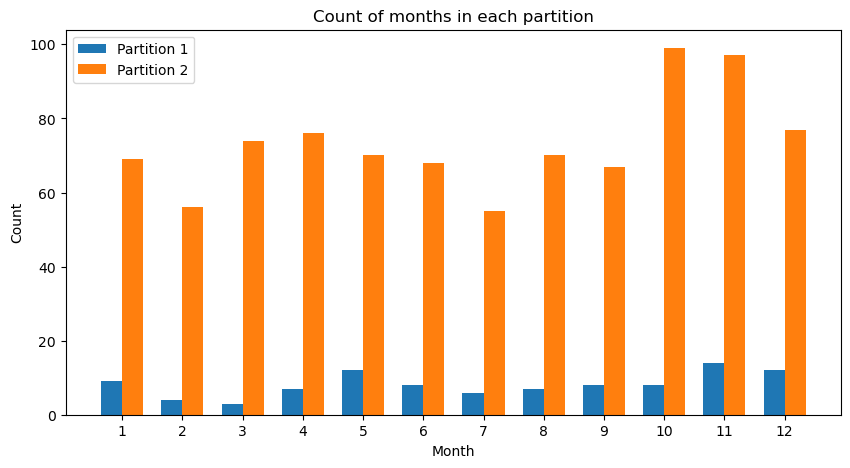

In [11]:
site = sites[5]
print(site)
print('='*80)
data = load_site_data(site)
annotations = load_site_annotations(site)
print(f'Number of annotations: {len(annotations)}')
annotations = annotations[annotations['rank'] != 'UNKNOWN'] # drop UNKNOWN
print(f'Number of annotations (after filtering out UNKNOWN): {len(annotations)}')

# get number of dates in annotations under left.timestamp and right.timestamp
left_dates = annotations['left.timestamp'].dt.date
right_dates = annotations['right.timestamp'].dt.date
unique_dates = set(left_dates).union(set(right_dates))
print(f'Number of unique dates in annotations: {len(unique_dates)}')

# create an empty undirected graph
print('>>> Creating graph')
G = nx.Graph()
# iterate through rows of annotations and for each row, add an edge between the left and right timestamps
# creating nodes if they don't exist; and increasing the weight of the edge if it does exist
for _, row in annotations.iterrows():
    left = row['left.timestamp'].date()
    right = row['right.timestamp'].date()
    if not G.has_node(left):
        G.add_node(left)
    if not G.has_node(right):
        G.add_node(right)
    if G.has_edge(left, right):
        G[left][right]['weight'] += 1
    else:
        G.add_edge(left, right, weight=1)
# print the number of nodes (dates)
print(f'Number of nodes (dates): {G.number_of_nodes()}')
# print the number of edges (connections between dates)
print(f'Number of edges: {G.number_of_edges()}')
# print total edge weight
total_edge_weight = sum([G[u][v]['weight'] for u, v in G.edges()])
print(f'Total edge weight (num annotations): {total_edge_weight}')

# # add nodes for dates in the data if they don't exist if they are within 3 days of an existing node
# for timestamp in data['timestamp']:
#     date = timestamp.date()
#     if not G.has_node(date):
#         for node in G.nodes():
#             if abs((date - node).days) <= 1:
#                 G.add_node(date)
#                 break
# # print the number of nodes (dates)
# print(f'Number of nodes: {G.number_of_nodes()}')

# list number of connected components
print(f'Number of connected components: {nx.number_connected_components(G)}')
print('-'*80)

# use kernighan-lin algorithm to partition the graph into two sets
print('>>> Initializing graph partition')
target_num_train_days = int(0.9 * len(unique_dates))
target_num_test_days = len(unique_dates) - target_num_train_days
print(f'Target number of training days: {target_num_train_days}')
print(f'Target number of test days: {target_num_test_days}')
# randomly assign nodes to training and test sets
nodes = list(G.nodes())
np.random.seed(42)
np.random.shuffle(nodes)
train_nodes = nodes[:target_num_train_days]
test_nodes = nodes[target_num_train_days:]
# print the number of nodes in each set
print(f'Number of nodes in initial training set: {len(train_nodes)}')
print(f'Number of nodes in initial test set: {len(test_nodes)}')
# print the initial cut size
initial_cut_size = nx.algorithms.cuts.cut_size(G, train_nodes, test_nodes, weight='weight')
print(f'Initial cut size: {initial_cut_size}')

print('>>> Partitioning graph using Kernighan-Lin algorithm')
partition = nx.algorithms.community.kernighan_lin_bisection(G, weight='weight', max_iter=10, seed=42, partition=(train_nodes, test_nodes))
# print the number of nodes in each partition
print(f'Number of nodes in partition 1: {len(partition[0])}')
print(f'Number of nodes in partition 2: {len(partition[1])}')
cut_size_manual = sum([G[u][v]['weight'] for u, v in G.edges() if (u in partition[0] and v in partition[1]) or (v in partition[0] and u in partition[1])])
print(f'Cut size (manual): {cut_size_manual}')
cut_size_nx = nx.algorithms.cuts.cut_size(G, partition[0], partition[1], weight='weight')
print(f'Cut size (nx): {cut_size_nx}')
# print total weight of edges in each partition
total_weight_partition1 = sum([G[u][v]['weight'] for u, v in G.edges() if u in partition[0] and v in partition[0]])
total_weight_partition2 = sum([G[u][v]['weight'] for u, v in G.edges() if u in partition[1] and v in partition[1]])
print(f'Total weight of edges in partition 1: {total_weight_partition1}')
print(f'Total weight of edges in partition 2: {total_weight_partition2}')
# plot the count of months in each partition
partition1_month_counts = Counter([date.month for date in partition[0]])
partition2_month_counts = Counter([date.month for date in partition[1]])
partition1_month_counts = {
    k:partition1_month_counts[k] if k in partition1_month_counts else 0 for k in range(1, 13)
}
partition2_month_counts = {
    k:partition2_month_counts[k] if k in partition2_month_counts else 0 for k in range(1, 13)
}

# plot the count of months in each partition
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.35
months = list(range(1, 13))
ax.bar(np.array(months) - bar_width/2, partition1_month_counts.values(), bar_width, label='Partition 1')
ax.bar(np.array(months) + bar_width/2, partition2_month_counts.values(), bar_width, label='Partition 2')
ax.set_xlabel('Month')
ax.set_ylabel('Count')
ax.set_title('Count of months in each partition')
ax.set_xticks(months)
ax.set_xticklabels([f'{m}' for m in months])
ax.legend()
plt.show()


2022-04-07 08:15:33-04:00 1.591651211
2022-04-08 08:15:34-04:00 5.454066951555555


/tmp/ipykernel_314049/4220042228.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


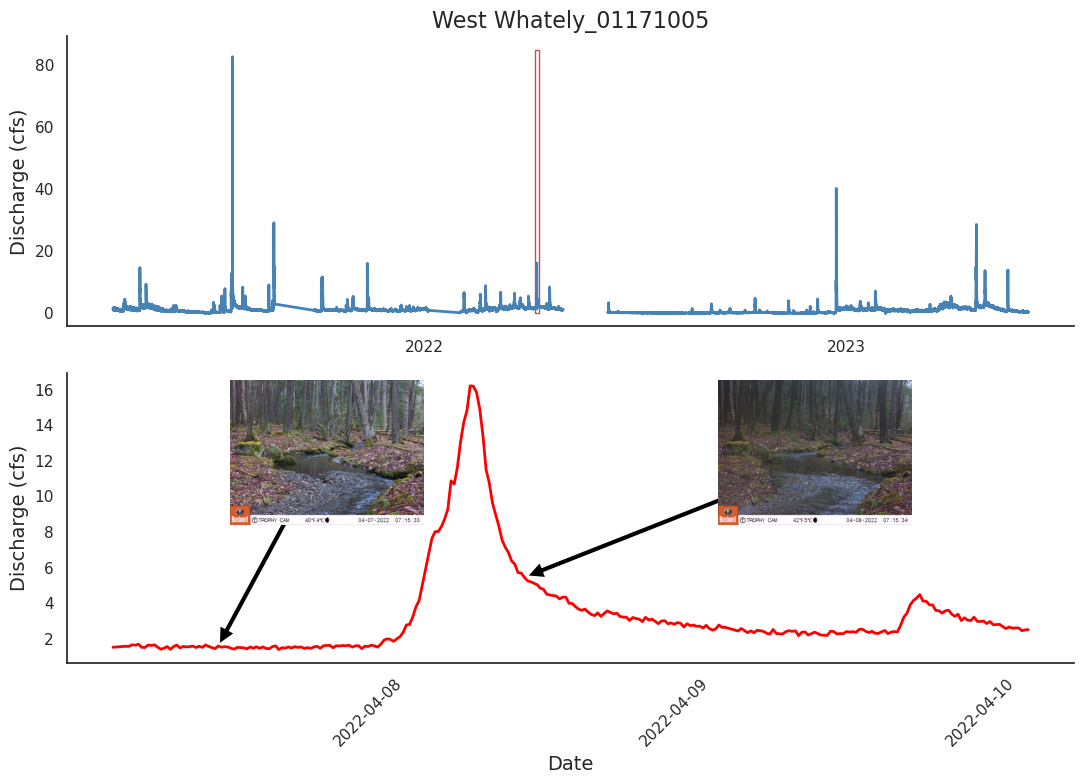

In [18]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

# Figure to illustrate our task
sns.set(rc={'figure.figsize':(11, 8)}, style="white")

# plot timeseries of streamflow for the first site
site = sites[-1]
data = load_site_data(site)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1)

# Plot timeseries of streamflow for the first site on the first subplot
ax1.plot(data['timestamp'], data['value'], linewidth=2, color='steelblue', label='Main plot')

# Set title and labels for the first subplot
ax1.set_title(f'{site}', fontsize=16)
ax1.set_ylabel('Discharge (cfs)', fontsize=14)

# Improve x-axis for the first subplot
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Plot the same data on the second subplot but for a specific time range
# # convert the start and end dates to timezone-aware Timestamps
start_date = pd.to_datetime('2022-04-07').tz_localize('US/Eastern')
end_date = pd.to_datetime('2022-04-10').tz_localize('US/Eastern')

rect = patches.Rectangle((start_date, 0), 
                         end_date - start_date, 
                         85, 
                         linewidth=1, edgecolor='r', facecolor='none')
ax1.add_patch(rect)

# Plot the same data on the second subplot but for a specific time range
ax2.plot(data.loc[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date), 'timestamp'], 
         data.loc[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date), 'value'], 
         linewidth=2, color='red', label='Second subplot')
# Set labels for the second subplot
ax2.set_ylabel('Discharge (cfs)', fontsize=14)
ax2.set_xlabel('Date', fontsize=14)

# Improve x-axis for the second subplot
ax2.xaxis.set_major_locator(mdates.DayLocator())
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)

# Remove the top and right spines from the second subplot
sns.despine(ax=ax2)

# Get a low flow image
img1_data = data.loc[(data['timestamp'].dt.year == 2022) & (data['timestamp'].dt.month==4) & (data['timestamp'].dt.day==7)].iloc[30]
img1 = plt.imread(Path(DATA_DIR, site, 'FLOW_CFS', img1_data['filename']))
img1_timestamp = img1_data['timestamp']
img1_flow = img1_data['value']
print(img1_timestamp, img1_flow)
# Plot the image in an inset
ax_inset = inset_axes(ax2, width="50%", height="50%", loc='upper left')
ax_inset.imshow(img1)
ax_inset.axis('off')
# Add an arrow from the inset image to the corresponding point in the plot
ax2.annotate('', xy=(img1_timestamp, img1_flow), xycoords='data',
             xytext=(0.25, 0.7), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.01),
             horizontalalignment='right', verticalalignment='top')

# Get a high flow image
img2_data = data.loc[(data['timestamp'].dt.year == 2022) & (data['timestamp'].dt.month==4) & (data['timestamp'].dt.day==8)].iloc[30]
img2 = plt.imread(Path(DATA_DIR, site, 'FLOW_CFS', img2_data['filename']))
img2_timestamp = img2_data['timestamp']
img2_flow = img2_data['value']
print(img2_timestamp, img2_flow)
# Plot the image in an inset
ax_inset = inset_axes(ax2, width="50%", height="50%", loc='upper right')
ax_inset.imshow(img2)
ax_inset.axis('off')
# Add an arrow from the inset image to the corresponding point in the plot
ax2.annotate('', xy=(img2_timestamp, img2_flow), xycoords='data',
             xytext=(0.75, 0.7), textcoords='axes fraction',
             arrowprops=dict(facecolor='black', shrink=0.01),
             horizontalalignment='right', verticalalignment='top')




plt.tight_layout()
plt.show()

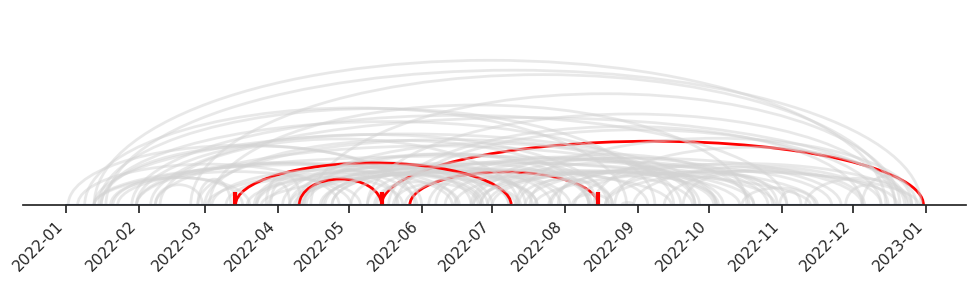

In [76]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import seaborn as sns

# Create a time series
time_series = pd.date_range(start='1/1/2022', end='12/31/2022')

# Create a figure and a subplot
fig, ax = plt.subplots(figsize=(10, 3))

# Plot the time series with zeros for the y-value
ax.plot(time_series, [0]*len(time_series))

# Set the x-axis to handle dates correctly
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Show major ticks for the months on the x-axis
ax.tick_params(axis='x', which='major', bottom=True)

# Don't display the tick values on the y-axis
ax.yaxis.set_ticklabels([])

# Draw X arcs with randomly sampled start and end dates
dates = pd.date_range(start='1/1/2022', end='12/31/2022').to_pydatetime().tolist()
target_dates = [pd.to_datetime('2022-03-14'), pd.to_datetime('2022-05-15'), pd.to_datetime('2022-08-15')]  # target dates
for i in range(100):
    start_date, end_date = np.random.choice(dates, 2, replace=False)
    if start_date > end_date:
        start_date, end_date = end_date, start_date
    mid_date = start_date + (end_date - start_date) / 2
    num_days_between = (end_date - start_date).days
    max_height = num_days_between / 365
    height = np.random.uniform(0.1, 0.5*max_height)  # vary the height of the arcs
    if (start_date in target_dates) or (end_date in target_dates):
        color = 'red'  # color arcs ending on target date in red
        alpha = 1  # make red arcs fully opaque
    else:
        color = 'lightgrey'
        alpha = 0.5  # make grey arcs semi-transparent
    arc = patches.Arc((mdates.date2num(mid_date), 0), 
                      mdates.date2num(end_date) - mdates.date2num(start_date), 
                      height, 
                      theta1=0, theta2=180, edgecolor=color, linewidth=2, alpha=alpha)
    ax.add_patch(arc)

# Highlight the ticks at the target dates in red
for date in target_dates:
    ax.vlines(x=mdates.date2num(date), ymin=0, ymax=0.02, color='red', linewidth=3)

ax.set_ylim(0, 0.3)
sns.despine(ax=ax, left=True, top=True, right=True) # hide top and right spines

plt.tight_layout()
plt.show()

In [35]:
table_rows = []
table2_rows = []
for site in sites:
    data = load_site_data(site)
    annotations = load_site_annotations(site)
    break
    
    # get all dates included in data under the timestamp col
    data_dates = reduce(lambda a, b: a.union(b), [set(data['timestamp'].dt.date)])
    data_dates = sorted(data_dates)
    # get all dates included in annotations under either left.timestamp or right.timestamp cols
    annotation_dates = reduce(lambda a, b: a.union(b), [set(annotations[col].dt.date) for col in ['left.timestamp', 'right.timestamp']])
    annotation_dates = sorted(annotation_dates)
    # get dates without annotations
    no_annotation_dates = [date for date in data_dates if date not in annotation_dates]
    pct_no_annotation_dates = len(no_annotation_dates) / len(data_dates) * 100
    # get data rows without annotations
    no_annotation_data = data[data['timestamp'].dt.date.isin(no_annotation_dates)]
    # filter nighttime data
    no_annotation_data_daytime = filter_by_hour(no_annotation_data, 7, 18) # 7AM to 7PM
    # get the months in descending order of frequency in the no_annotation_data_daytime
    month_counts = no_annotation_data_daytime['timestamp'].dt.month.value_counts().sort_index(ascending=False).to_dict()
    # ensure all months are included
    all_months = {i: 0 for i in range(1, 13)}
    all_months.update(month_counts)
    month_counts = all_months

    table_rows.append([
        site,
        len(data_dates),
        len(annotation_dates),
        len(no_annotation_dates),
        pct_no_annotation_dates,
        len(no_annotation_data),
        len(no_annotation_data_daytime)
    ])
    
    table2_rows.append([site] + list(month_counts.values()))

table = pd.DataFrame(table_rows, columns=[
    'Site Name', 
    'Total Date Count', 
    'Annotated Date Count', 
    'Unannotated Date Count', 
    'Percentage of Unannotated Dates', 
    'Unannotated Data Row Count', 
    'Daytime Unannotated Data Row Count'
])

table2 = pd.DataFrame(table2_rows, columns=['Site Name'] + [f'Month {i}' for i in range(1, 13)])

display(table)
display(table2)

,Site Name,Total Date Count,Annotated Date Count,Unannotated Date Count,Percentage of Unannotated Dates,Unannotated Data Row Count,Daytime Unannotated Data Row Count
0,Avery Brook_Bridge_01171000,805,688,117,14.534161,11087,5534
1,Avery Brook_River Left_01171000,915,845,70,7.650273,6418,3163
2,Avery Brook_River Right_01171000,917,851,66,7.197383,6162,3059
3,Avery Brook_Side_01171000,747,626,121,16.198126,11472,5727
4,Sanderson Brook_01171010,910,783,127,13.956044,11826,6011
5,West Branch Swift River_01174565,1151,1050,101,8.774978,434,306
6,West Brook 0_01171100,585,528,57,9.743590,5417,2701
7,West Brook Lower_01171090,1568,1327,241,15.369898,11741,5858
8,West Brook Reservoir_01171020,760,696,64,8.421053,6096,3040
9,West Brook Upper_01171030,919,858,61,6.637650,1474,735


,Site Name,Month 1,Month 2,Month 3,Month 4,Month 5,Month 6,Month 7,Month 8,Month 9,Month 10,Month 11,Month 12
0,Avery Brook_Bridge_01171000,159,0,0,0,0,0,0,0,1008,1440,1439,1488
1,Avery Brook_River Left_01171000,159,10,0,48,48,0,0,18,0,96,1296,1488
2,Avery Brook_River Right_01171000,170,0,0,0,12,0,0,0,0,45,1344,1488
3,Avery Brook_Side_01171000,159,0,0,0,0,0,0,0,1152,1488,1440,1488
4,Sanderson Brook_01171010,411,0,0,0,0,16,0,0,1166,1488,1440,1490
5,West Branch Swift River_01174565,33,28,45,20,10,19,18,35,34,19,30,15
6,West Brook 0_01171100,109,0,0,0,0,0,0,0,0,0,1104,1488
7,West Brook Lower_01171090,619,195,261,67,105,197,144,127,228,747,1533,1635
8,West Brook Reservoir_01171020,0,0,0,0,0,0,48,0,0,576,1440,976
9,West Brook Upper_01171030,48,105,72,45,16,89,36,48,60,60,96,60


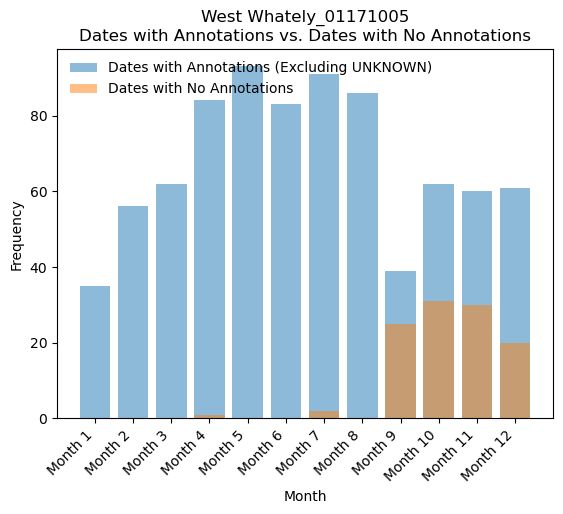

In [50]:
annotations_excl_unknown = annotations[annotations['rank'] != 'UNKNOWN']
annotations_excl_unknown_dates = reduce(lambda a, b: a.union(b), [set(annotations_excl_unknown[col].dt.date) for col in ['left.timestamp', 'right.timestamp']])
annotations_excl_unknown_dates = sorted(annotations_excl_unknown_dates)
# what months are the annotations_excl_unknown_dates in?
annotations_excl_unknown_month_counts = Counter([date.month for date in annotations_excl_unknown_dates])
annotations_excl_unknown_month_counts = {i: annotations_excl_unknown_month_counts[i] for i in range(1, 13)}
# what dates don't have annotations?
no_annotation_dates = [date for date in data_dates if date not in annotations_excl_unknown_dates]
# what months are the no_annotation_dates in?
no_annotation_month_counts = Counter([date.month for date in no_annotation_dates])
no_annotation_month_counts = {i: no_annotation_month_counts[i] for i in range(1, 13)}

# plot
fig, ax = plt.subplots()
ax.bar(annotations_excl_unknown_month_counts.keys(), annotations_excl_unknown_month_counts.values(), label='Dates with Annotations (Excluding UNKNOWN)', color='tab:blue', alpha=0.5)
ax.bar(no_annotation_month_counts.keys(), no_annotation_month_counts.values(), label='Dates with No Annotations', color='tab:orange', alpha=0.5)
ax.set_title(f"{site}\nDates with Annotations vs. Dates with No Annotations")
ax.set_xlabel('Month')
ax.set_ylabel('Frequency')
ax.set_xticks(range(1, 13))
ax.set_xticklabels([f'Month {i}' for i in range(1, 13)], rotation=45, ha='right')
ax.legend(frameon=False, loc='upper left')
plt.show()


In [21]:
corner_colors = ("lightgrey", "green", "blue", "red")
n = (10, 10)
cmap = xycmap.custom_xycmap(corner_colors, n)

def plot_annotations(ax, annotations, title='Scatterplot of Annotations', **kwargs):
    # Set default plot kwargs
    kwargs.setdefault('alpha', 0.8)
    kwargs.setdefault('s', 10)  # default marker size

    # Determine the earlier and later timestamps
    earlier_timestamp = np.minimum(annotations['left.timestamp'], annotations['right.timestamp'])
    later_timestamp = np.maximum(annotations['left.timestamp'], annotations['right.timestamp'])

    # Determine the earlier and later flow values
    earlier_flow = np.where(annotations['left.timestamp'] <= annotations['right.timestamp'], annotations['left.value'], annotations['right.value'])
    later_flow = np.where(annotations['left.timestamp'] > annotations['right.timestamp'], annotations['left.value'], annotations['right.value'])

    # Map the earlier and later flow values to deciles
    earlier_flow_deciles = pd.qcut(earlier_flow, q=10, labels=False, duplicates='drop')
    later_flow_deciles = pd.qcut(later_flow, q=10, labels=False, duplicates='drop')

    # Map the deciles to colors
    colors = xycmap.bivariate_color(sx=earlier_flow_deciles / 9, sy=later_flow_deciles / 9, cmap=cmap)

    # Create a scatterplot with the combined colors
    ax.scatter(earlier_timestamp, later_timestamp, color=colors, **kwargs)
    ax.set_xlabel('Earlier Timestamp')
    ax.set_ylabel('Later Timestamp')
    ax.set_title(title)

    # Improve plot appearance according to Tufte's principles
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Rotate and align the x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    return earlier_flow_deciles, later_flow_deciles


Avery Brook_Bridge_01171000


Loaded 73876 images
Excluded 36909 nighttime images
Loaded 5148 annotations
Excluded 747 annotations with rank "UNKNOWN"
Excluded 434 annotations with left or right imageId not in data_daytime
Excluded 0 annotations with user_id "9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17"
Excluded 155 annotations with NaN values for flow
Avery Brook_River Left_01171000
Loaded 84661 images
Excluded 40991 nighttime images
Loaded 2516 annotations
Excluded 109 annotations with rank "UNKNOWN"
Excluded 0 annotations with left or right imageId not in data_daytime
Excluded 0 annotations with user_id "9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17"
Excluded 232 annotations with NaN values for flow
Avery Brook_River Right_01171000
Loaded 85474 images
Excluded 42525 nighttime images
Loaded 2500 annotations
Excluded 105 annotations with rank "UNKNOWN"
Excluded 0 annotations with left or right imageId not in data_daytime
Excluded 0 annotations with user_id "9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17"
Excluded 197 annotations with NaN v

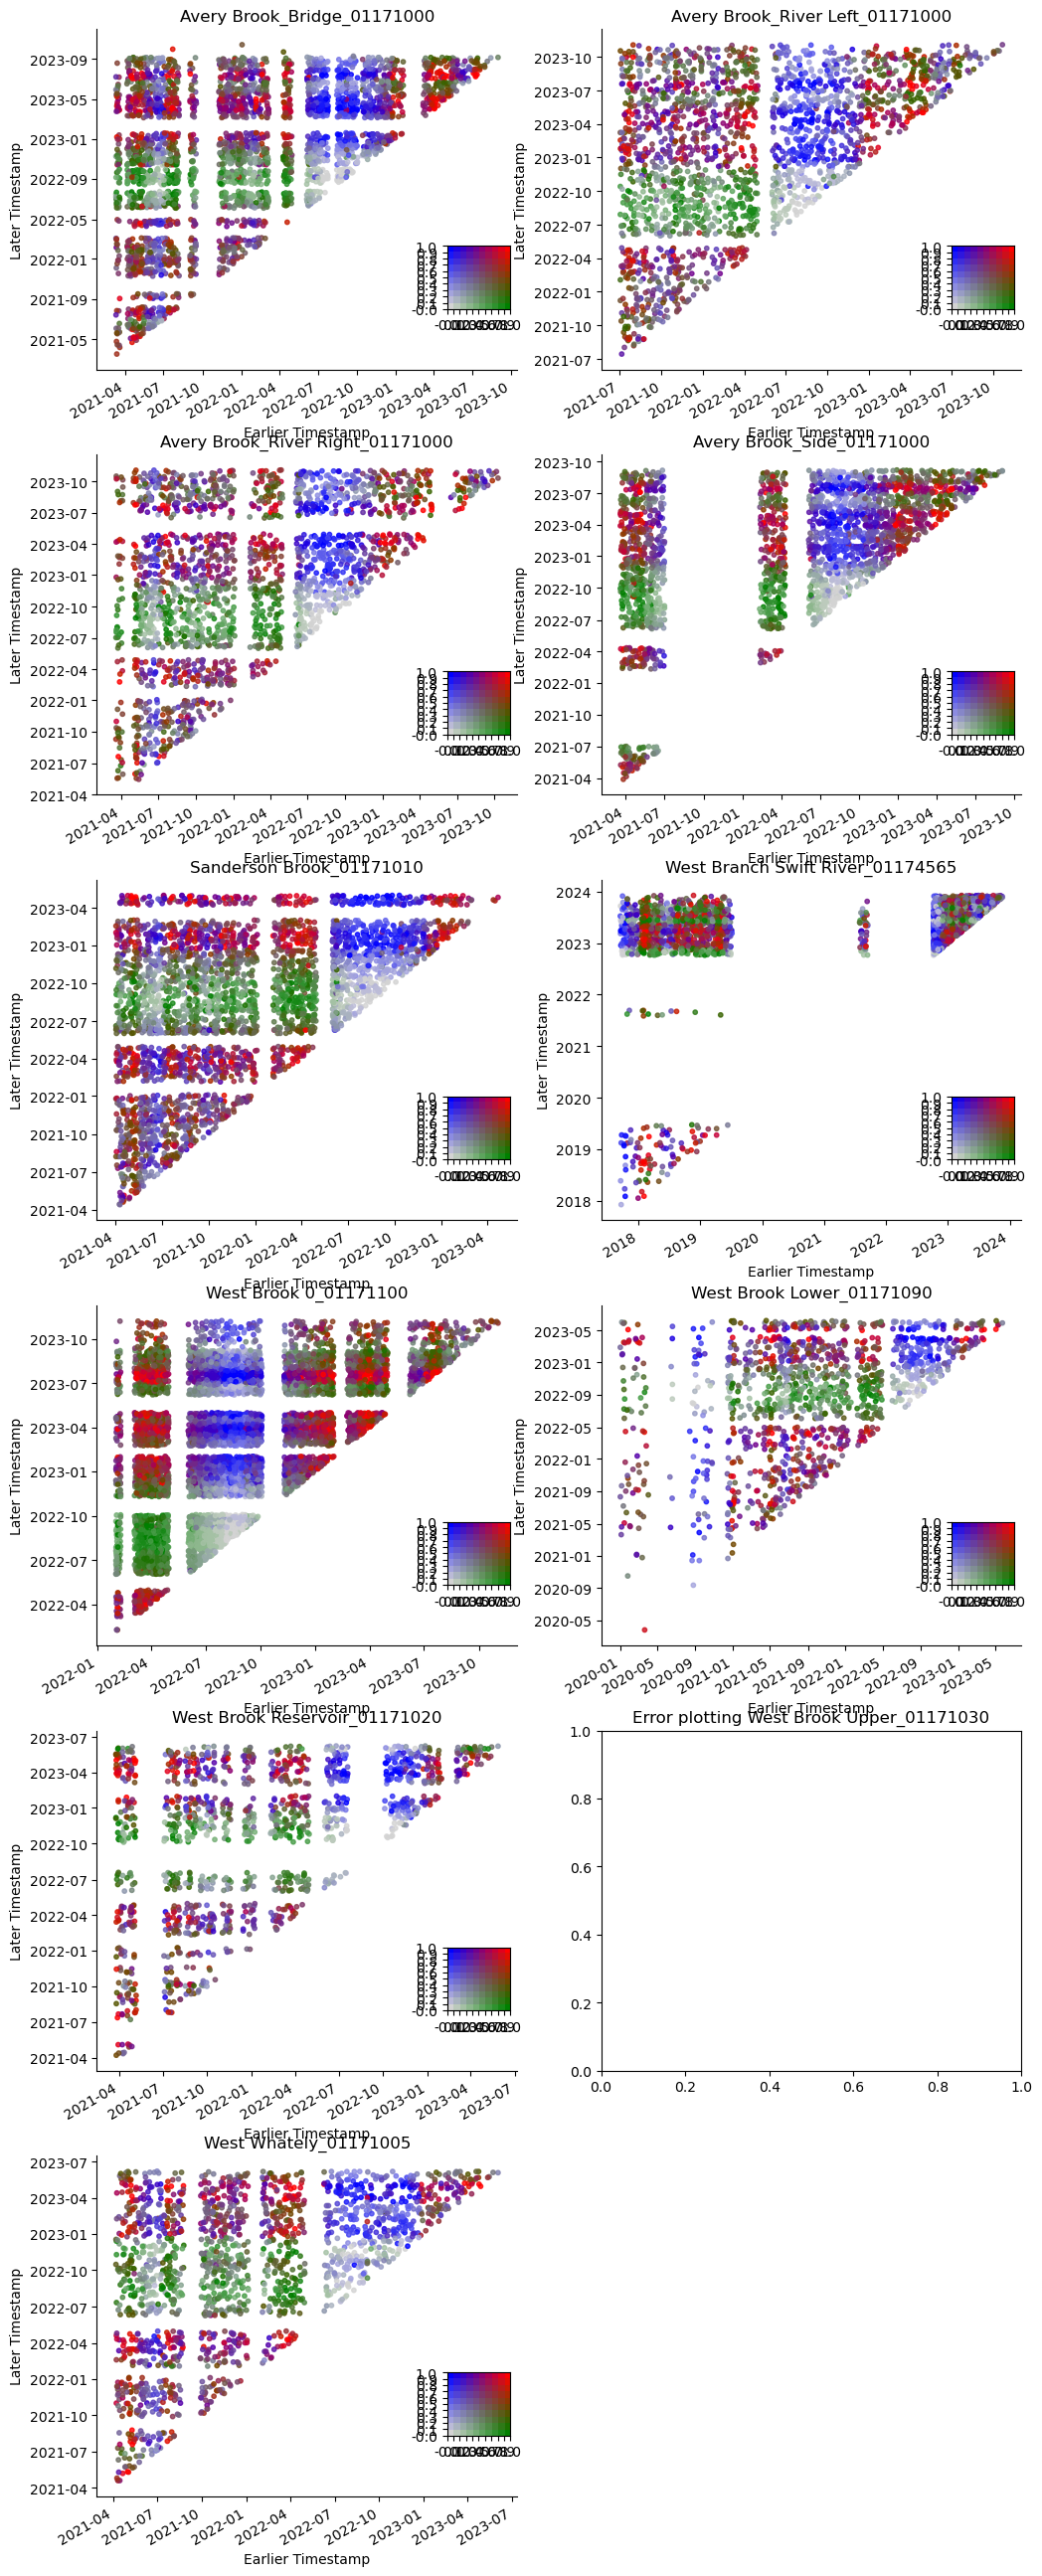

In [25]:
# Determine the number of rows needed for the subplots
n_rows = int(np.ceil(len(sites) / 2))
fig, axs = plt.subplots(len(sites), 2, figsize=(12, n_rows*10))  # Adjust the figure size as needed
axs = axs.flatten()  # Flatten the array of axes for easier indexing


for i, site in enumerate(sites):
    print(site)

    # load site data
    data = load_site_data(site)
    print(f'Loaded {len(data)} images')
    # exclude nighttime images
    df_filters = [
            (filter_by_hour, {"min_hour": 7, "max_hour": 18}),
        ]
    data_daytime = reduce(lambda _df, filter: _df.pipe(filter[0], **filter[1]), df_filters, data)
    print(f'Excluded {len(data) - len(data_daytime)} nighttime images')
    annotations = load_site_annotations(site)
    print(f'Loaded {len(annotations)} annotations')
    # exclude rank = "UNKNOWN"
    annotations_tmp = annotations[annotations['rank'] != 'UNKNOWN']
    print(f'Excluded {len(annotations) - len(annotations_tmp)} annotations with rank "UNKNOWN"')
    annotations = annotations_tmp
    # include only pairs whose left.imageId and right.imageId are in data_daytime
    annotations_tmp = annotations[annotations['left.imageId'].isin(data_daytime['image_id'])]
    annotations = annotations_tmp[annotations_tmp['right.imageId'].isin(data_daytime['image_id'])]
    print(f'Excluded {len(annotations_tmp) - len(annotations)} annotations with left or right imageId not in data_daytime')
    annotations = annotations_tmp
    # drop user_id = "9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17"
    annotations_tmp = annotations[annotations['user_id'] != '9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17']
    print(f'Excluded {len(annotations) - len(annotations_tmp)} annotations with user_id "9bc0d5e3-a871-4ffa-ae4f-1cbc44b0ea17"')
    annotations = annotations_tmp
    # remove rows with NaN values for flow
    annotations_tmp = annotations.dropna(subset=['left.value', 'right.value'])
    print(f'Excluded {len(annotations) - len(annotations_tmp)} annotations with NaN values for flow')
    annotations = annotations_tmp
    # Plot annotations
    ax = axs[i]
    try:
        left_flow_deciles, right_flow_deciles = plot_annotations(ax, annotations, title=f'{site}')
        # print(left_flow_deciles.isna().any())
        # print(right_flow_deciles.isna().any())

        # Add a colorbar
        cax = inset_axes(ax, width="15%", height="50%", loc='lower right')  # Adjust the width, height, and location as needed
        cax = xycmap.bivariate_legend(ax=cax, sx=left_flow_deciles / 9, sy=right_flow_deciles / 9, cmap=cmap)

    except Exception as e:
        print(f'Error plotting {site}: {e}')
        ax.set_title(f'Error plotting {site}')

# Remove any unused subplots
for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

# Add more vertical spacing between the rows of subplots
plt.subplots_adjust(hspace=0.25)  # Adjust the hspace parameter as needed

plt.show()

In [11]:
def split_pairs(df):
    data = df.copy()
    # get min and max timestamp for each pair
    data['min_timestamp'] = data[['left.timestamp', 'right.timestamp']].min(axis=1)
    # get 90th percentile of min timestamp
    min_timestamp_90p = data['min_timestamp'].quantile(0.9)
    # rename column left.imageId to image_id_1
    data = data.rename(columns={
        'left.imageId': 'image_id_1',
        'left.timestamp': 'timestamp_1',
        'left.filename': 'filename_1',
        'left.flow_cfs': 'label_1',
        'right.imageId': 'image_id_2',
        'right.timestamp': 'timestamp_2',
        'right.filename': 'filename_2',
        'right.flow_cfs': 'label_2',
    })
    # assign pair_label = 0 if rank="SAME", 1 if rank="LEFT", -1 if rank="RIGHT"
    data['pair_label'] = data['rank'].map({
        'SAME': 0,
        'LEFT': 1,
        'RIGHT': -1
    })

    # split into train/val and test by both timestamp_1 and timestamp_2
    data_train_val = data[(data['timestamp_1'] < min_timestamp_90p) & (data['timestamp_2'] < min_timestamp_90p)]
    data_test = data[(data['timestamp_1'] >= min_timestamp_90p) & (data['timestamp_2'] >= min_timestamp_90p)]
    
    # split 20% of train/val into val
    data_train = data_train_val.sample(frac=0.8, random_state=42)
    data_val = data_train_val.drop(data_train.index)

    # drop min_timestamp column
    data_train = data_train.drop(columns=['min_timestamp'])
    data_val = data_val.drop(columns=['min_timestamp'])
    data_test = data_test.drop(columns=['min_timestamp'])

    return data_train, data_val, data_test


tr_annot, val_annot, test_annot = split_pairs(annotations)

In [12]:
print(len(tr_annot), len(val_annot), len(test_annot))
# sum
print(len(tr_annot) + len(val_annot) + len(test_annot))

# assert that train doesn't overlap temporally with test
test_min_timestamp = min(test_annot['timestamp_1'].min(), test_annot['timestamp_2'].min())
assert tr_annot['timestamp_1'].max() < test_min_timestamp, "train overlaps with test"
assert tr_annot['timestamp_2'].max() < test_min_timestamp, "train overlaps with test"

# assert that val doesn't overlap temporally with test
assert val_annot['timestamp_1'].max() < test_min_timestamp, "val overlaps with test"
assert val_annot['timestamp_2'].max() < test_min_timestamp, "val overlaps with test"



1710 427 406
2543


In [13]:
# # create directory if it doesn't exist
# exp_name = 'temporal_test.vary_n_train_annot'
# Path(SAVE_DIR, site, 'FLOW_CFS', exp_name).mkdir(parents=True, exist_ok=True)
# # save train/val/test annotations
# tr_annot.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-train.csv'))
# val_annot.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-val.csv'))
# test_annot.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, 'pairs-test.csv'))

# # create nested subsets of train annotations
# # subset sizes are multiples of 200 up to len(tr_annot)
# subset_sizes = [200 * i for i in range(1, len(tr_annot) // 200 + 1)]
# # create random permutation of indices
# subset_indices = np.random.permutation(len(tr_annot))
# # create subsets
# for subset_size in subset_sizes:
#     subset = tr_annot.iloc[subset_indices[:subset_size]]
#     subset.to_csv(Path(SAVE_DIR, site, 'FLOW_CFS', exp_name, f'pairs-train-{subset_size}.csv'))
#     print(f'saved subset of size {subset_size}')


saved subset of size 200
saved subset of size 400
saved subset of size 600
saved subset of size 800
saved subset of size 1000
saved subset of size 1200
saved subset of size 1400
saved subset of size 1600


In [19]:
annotations.head(3)

,annotation_id,user_id,station_id,station_name,duration_sec,n,url,rank,comment,left.imageId,...,left.url,left.filename,right.timestamp,right.value,right.url,right.filename,delta_value,avg_value,rel_delta_value,true_rank
0,732,1fcc2eca-0043-488b-b14f-1d42fa2a0717,68,West Branch Swift River_01174565,421.33,20,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,LEFT,NaN,1738056,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/b2eb4fe1-17d3-4f3a-8609-4d9dcebea954...,2023-06-20 20:00:00+00:00,8.22,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/08450dcc-8521-4961-a30e-4c6741a84d11...,19.98,18.21,1.097199,LEFT
1,732,1fcc2eca-0043-488b-b14f-1d42fa2a0717,68,West Branch Swift River_01174565,421.33,20,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,LEFT,NaN,1994446,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/4b21380b-a962-4778-a590-60829a47c5ce...,2023-01-09 17:45:00+00:00,26.20,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/b2eb4fe1-17d3-4f3a-8609-4d9dcebea954...,29.30,40.85,0.717258,LEFT
2,732,1fcc2eca-0043-488b-b14f-1d42fa2a0717,68,West Branch Swift River_01174565,421.33,20,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,RIGHT,NaN,920659,...,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/149ec5ca-6f26-4f15-a9d9-d9c979439645...,2023-03-25 15:00:00+00:00,57.20,https://usgs-chs-conte-prod-fpe-storage.s3.ama...,imagesets/4b21380b-a962-4778-a590-60829a47c5ce...,21.20,46.60,0.454936,RIGHT
